In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit

In [74]:
# check device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:0


In [75]:
# Load your data
df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [76]:
# Preprocess the dataframe
df["arrivalDate"] = pd.to_datetime(df["arrivalDate"])
df["sailingDate"] = pd.to_datetime(df["sailingDate"])
df["duration"] = (df["sailingDate"] - df["arrivalDate"]) / pd.Timedelta(days=1)
df["month"] = df["arrivalDate"].dt.month
df = df.dropna()

In [77]:
# cap any outliers - normalize this?
cap = df['duration'].quantile(.99)
df['capped_duration'] = df['duration'].apply(lambda x: min(x, cap))

In [78]:
# Sort and filter data
df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
df['next_unlocode'] = df.groupby('IMO')['place.unlocode'].shift(-1)
df['is_last_imo'] = df['IMO'] != df['IMO'].shift(-1)
df = df[~df["is_last_imo"]]
df = df[df["Event_Type"] != "ARRIVAL"]

In [79]:
# Drop unnecessary columns
df = df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate", "duration"])

# Rename columns for consistency
df = df.rename(columns={'place.unlocode': 'current_unlocode', 'place.placeName': 'port_name', 'vessel.vesselType': 'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name'})

In [80]:
df['vessel_type'].unique()

array(['Vessel Type (unspecified)', 'tug/supply', 'semi-sub HL vessel',
       'vehicle carrier', 'fully cellular containership',
       'general cargo with container capacity', 'product tanker',
       'general cargo', 'passenger (cruise)', 'chemical tanker',
       'Combined chemical and oil tanker', 'crude oil tanker',
       'bulk carrier', 'tug', 'Liquefied Petroleum Gas Carrier',
       'asphalt tanker', 'Roll On Roll Off', 'Tanker (unspecified)',
       'patrol ship'], dtype=object)

In [81]:
df['vessel_type'].value_counts()

vessel_type
fully cellular containership             79010
vehicle carrier                          38120
Combined chemical and oil tanker         15148
product tanker                           13457
crude oil tanker                          6788
chemical tanker                           4745
passenger (cruise)                        4377
bulk carrier                              3801
general cargo with container capacity     3242
general cargo                              545
tug                                        473
tug/supply                                 324
Liquefied Petroleum Gas Carrier            233
patrol ship                                127
Roll On Roll Off                            94
semi-sub HL vessel                          85
Tanker (unspecified)                        75
asphalt tanker                              69
Vessel Type (unspecified)                   39
Name: count, dtype: int64

In [82]:
# currently using only one vessel type
df = df[df['vessel_type'] == 'vehicle carrier']
# drop vessel_type column
df = df.drop(columns=['vessel_type'])

In [83]:
# Focus on filtering over here
# Filter ports with fewer than 5 appearances in both columns
port_counts = pd.concat([df['current_unlocode'], df['next_unlocode']]).value_counts()
threshhold = 100
valid_ports = port_counts[port_counts >= threshhold].index
df = df[df['current_unlocode'].isin(valid_ports) & df['next_unlocode'].isin(valid_ports)]

In [84]:
# print value counts of current_unlocode and next_unlocode
curvalcounts = df['current_unlocode'].value_counts()
nextvalcounts = df['next_unlocode'].value_counts()

In [85]:
df['traffic_flow'] = df.groupby('current_unlocode')['current_unlocode'].transform('count')

In [86]:
# Encode categorical features
label_encoders = {}
cols = ['port_name', 'country_name', 'place_type']
# cols = ['port_name', 'country_name', 'vessel_type', 'place_type']
for column in cols:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [87]:
# One-hot encode the port_unlocode feature
lb_in = LabelBinarizer(sparse_output=False)
unlocode_onehot = lb_in.fit_transform(df[['current_unlocode']])
df_unlocode_onehot = pd.DataFrame(unlocode_onehot, columns=lb_in.classes_)

In [88]:
lb_y = LabelBinarizer(sparse_output=False)
y_onehot = lb_y.fit_transform(df[['next_unlocode']])

In [89]:
y_onehot_df = pd.DataFrame(y_onehot, columns=lb_y.classes_)

In [90]:
df

,port_name,current_unlocode,place_type,country_name,month,capped_duration,next_unlocode,traffic_flow
272437,133,KRUSN,0,43,1,1.323611,KRKAN,460
272439,44,KRKAN,1,43,1,0.400845,KRUSN,353
272441,133,KRUSN,0,43,1,2.585799,KRKAN,460
272443,44,KRKAN,1,43,1,0.391921,KRUSN,353
272445,133,KRUSN,0,43,1,1.681192,USPDX,460
...,...,...,...,...,...,...,...,...
134991,62,JPKND,0,24,8,0.454988,CNSGH,380
134993,117,CNSGH,0,38,8,0.497361,SGSIN,724
134995,119,SGSIN,0,44,8,0.757627,EGALY,1377
134997,36,EGALY,0,0,9,0.407523,ESBCN,90


In [91]:
# Add the one-hot encoded ports back to the dataframe
df = pd.concat([df.reset_index(drop=True), df_unlocode_onehot], axis=1)
df = df.drop(columns=['current_unlocode'])

In [92]:
# Prepare features
X = df.drop(columns=['next_unlocode'])
y = y_onehot
# print X and y shape
print(X.shape, y.shape)

(32734, 153) (32734, 147)


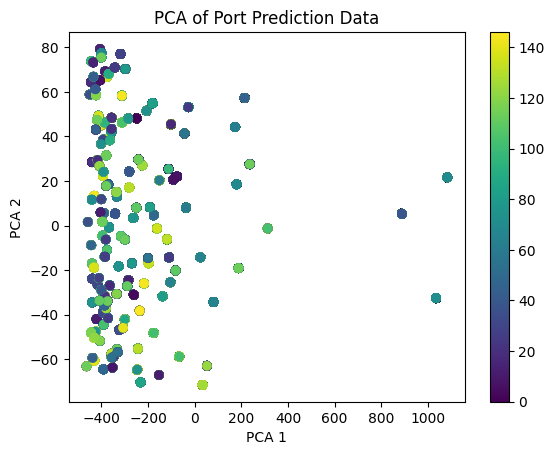

In [93]:
from sklearn.decomposition import PCA

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.argmax(axis=1), cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Port Prediction Data')
plt.colorbar()
plt.show()

Text(0.5, 0, 'PCA 3')

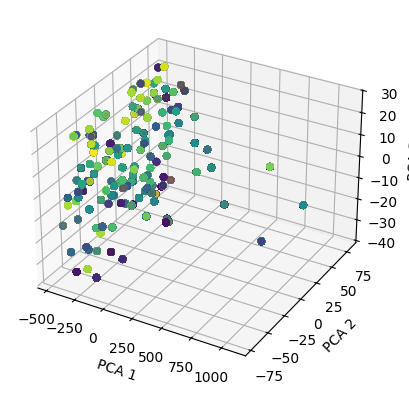

In [94]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

# 3D PCA
pca = PCA(n_components=3)
X_pca3 = pca.fit_transform(X)

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=y.argmax(axis=1), cmap='viridis')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

In [95]:
# Stratified train-test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y.argmax(axis=1)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# print out the shapes of the train and test data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (26187, 153), y_train shape: (26187, 147), X_test shape: (6547, 153), y_test shape: (6547, 147)


In [96]:
# Specify columns to scale
columns_to_scale = ['capped_duration', 'month', 'port_name', 'country_name', 'place_type', 'traffic_flow']
# columns_to_scale = ['capped_duration', 'month', 'port_name', 'country_name', 'vessel_type', 'place_type']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_train_scaled_part = scaler.fit_transform(X_train[columns_to_scale])

# Transform the test data
X_test_scaled_part = scaler.transform(X_test[columns_to_scale])

# Convert the scaled data back to DataFrames
X_train_scaled_part = pd.DataFrame(X_train_scaled_part, columns=columns_to_scale, index=X_train.index)
X_test_scaled_part = pd.DataFrame(X_test_scaled_part, columns=columns_to_scale, index=X_test.index)

# Drop the columns to be scaled from the original DataFrames
X_train_unscaled_part = X_train.drop(columns=columns_to_scale)
X_test_unscaled_part = X_test.drop(columns=columns_to_scale)

print(X_train_scaled_part.shape, X_train_unscaled_part.shape)
print(X_test_scaled_part.shape, X_test_unscaled_part.shape)

# Concatenate the scaled and unscaled parts
X_train = pd.concat([X_train_scaled_part, X_train_unscaled_part], axis=1)
X_test = pd.concat([X_test_scaled_part, X_test_unscaled_part], axis=1)

# Verify the shapes after scaling
print("Shapes after MinMax scaling:")
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

(26187, 6) (26187, 147)
(6547, 6) (6547, 147)
Shapes after MinMax scaling:
X_train.shape: (26187, 153)
X_test.shape: (6547, 153)


In [97]:
X_train.shape

(26187, 153)

In [98]:
print("Checking for NaNs or Infinities...")
print(f"X_train contains NaNs: {np.isnan(X_train.values).any()}")
print(f"X_train contains Infinities: {np.isinf(X_train.values).any()}")
print(f"y_train contains NaNs: {np.isnan(y_train).any()}")
print(f"y_train contains Infinities: {np.isinf(y_train).any()}")
print(f"X_test contains NaNs: {np.isnan(X_test.values).any()}")
print(f"X_test contains Infinities: {np.isinf(X_test.values).any()}")
print(f"y_test contains NaNs: {np.isnan(y_test).any()}")
print(f"y_test contains Infinities: {np.isinf(y_test).any()}")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Checking for NaNs or Infinities...
X_train contains NaNs: False
X_train contains Infinities: False
y_train contains NaNs: False
y_train contains Infinities: False
X_test contains NaNs: False
X_test contains Infinities: False
y_test contains NaNs: False
y_test contains Infinities: False
X_train shape: (26187, 153)
y_train shape: (26187, 147)
X_test shape: (6547, 153)
y_test shape: (6547, 147)


In [99]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


print(f"Unique labels in y_train: {np.unique(y_train.argmax(axis=1))}")
print(f"Unique labels in y_test: {np.unique(y_test.argmax(axis=1))}")

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

X_train_tensor shape: torch.Size([26187, 153])
y_train_tensor shape: torch.Size([26187, 147])
X_test_tensor shape: torch.Size([6547, 153])
y_test_tensor shape: torch.Size([6547, 147])
Unique labels in y_train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146]
Unique labels in y_test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40 

In [100]:
# print of shapes of tensors
print(f"X_train_tensor shape: {X_train_tensor.shape}", f"y_train_tensor shape: {y_train_tensor.shape}", f"X_test_tensor shape: {X_test_tensor.shape}", f"y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([26187, 153]) y_train_tensor shape: torch.Size([26187, 147]) X_test_tensor shape: torch.Size([6547, 153]) y_test_tensor shape: torch.Size([6547, 147])


In [101]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [102]:
class PortPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(PortPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
input_size = X_train_tensor.shape[1]
num_classes = y_train_tensor.shape[1]
hidden_size = 128

# TODO: Play around with the loss function and learning rate - you want it to fluctuate. Goal is to minimize the loss
model = PortPredictor(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=2000, mode='triangular')

In [103]:
X_train_tensor

tensor([[0.0687, 0.8182, 0.8151,  ..., 0.0000, 0.0000, 0.0000],
        [0.0450, 0.5455, 0.5959,  ..., 0.0000, 0.0000, 0.0000],
        [0.1422, 0.2727, 0.4726,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1540, 0.2727, 0.8151,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.2727, 0.5548,  ..., 0.0000, 0.0000, 0.0000],
        [0.0841, 0.4545, 0.6644,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [104]:
model

PortPredictor(
  (fc1): Linear(in_features=153, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=147, bias=True)
  (relu): ReLU()
)

In [105]:
# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train_model():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(targets, dim=1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        target_classes = torch.argmax(targets, dim=1)
        correct += (predicted == target_classes).sum().item()
        total += target_classes.size(0)
        
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

def test_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(targets, dim=1))
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            target_classes = torch.argmax(targets, dim=1)
            correct += (predicted == target_classes).sum().item()
            total += target_classes.size(0)
            
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy

In [106]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [107]:
num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_acc = train_model()
    test_loss, test_acc = test_model()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f'Epoch {epoch} [LR: {scheduler.get_last_lr()}], Train Loss: {train_loss:.4f}, Train Acc: {(100*train_acc):.4f}, Test Loss: {test_loss:.4f}, Test Acc: {(100*test_acc):.4f}')
    scheduler.step()

Epoch 0 [LR: [0.0001]], Train Loss: 4.7507, Train Acc: 4.2158, Test Loss: 4.5491, Test Acc: 4.8114
Epoch 1 [LR: [0.00010495000000000166]], Train Loss: 4.5177, Train Acc: 5.3691, Test Loss: 4.4731, Test Acc: 5.8042
Epoch 2 [LR: [0.00010989999999999892]], Train Loss: 4.4087, Train Acc: 5.9801, Test Loss: 4.2945, Test Acc: 7.9884
Epoch 3 [LR: [0.00011485000000000057]], Train Loss: 4.1246, Train Acc: 10.1272, Test Loss: 3.9458, Test Acc: 12.5859
Epoch 4 [LR: [0.00011979999999999783]], Train Loss: 3.8379, Train Acc: 13.5869, Test Loss: 3.7053, Test Acc: 16.6183
Epoch 5 [LR: [0.00012474999999999948]], Train Loss: 3.6333, Train Acc: 17.4323, Test Loss: 3.5332, Test Acc: 19.3371
Epoch 6 [LR: [0.00012970000000000115]], Train Loss: 3.4775, Train Acc: 19.8419, Test Loss: 3.3976, Test Acc: 20.4827
Epoch 7 [LR: [0.0001346499999999984]], Train Loss: 3.3512, Train Acc: 21.3121, Test Loss: 3.2812, Test Acc: 22.8807
Epoch 8 [LR: [0.00013960000000000003]], Train Loss: 3.2407, Train Acc: 22.5074, Test Lo

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\torch\optim\lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


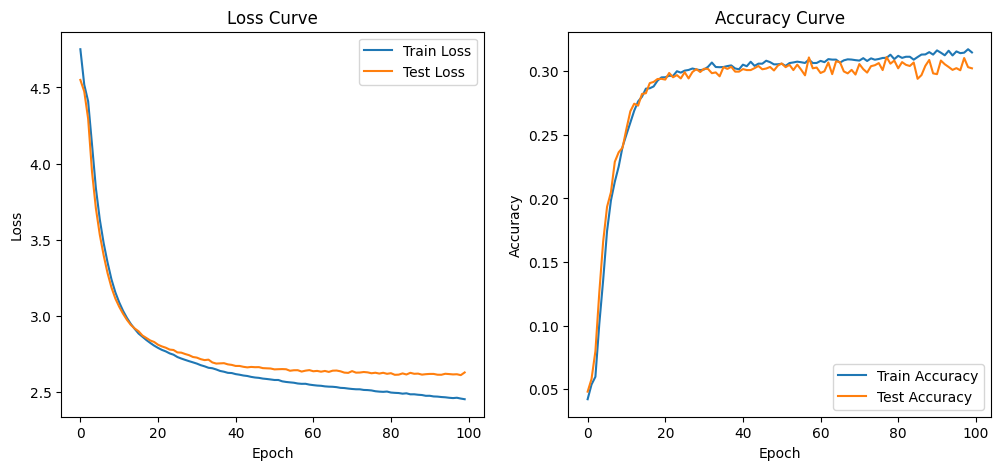

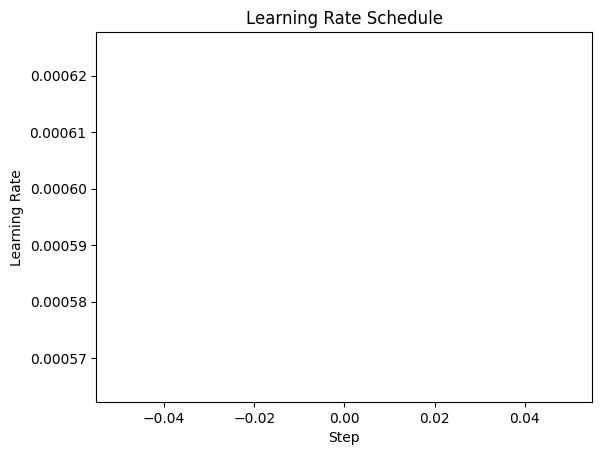

In [108]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# plot learning rate
plt.figure()
plt.plot(scheduler.get_lr())
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.show()